In [1]:
INSTALL_PACKAGES = False

# we're going to use tensorflow 2.14.0 and keras 2.14.0 because that's probably what the tutorial used
# https://developer.apple.com/metal/tensorflow-plugin/
# KerasCV installation: https://keras.io/keras_cv/#keras-2-installation
if INSTALL_PACKAGES:
    !pip install tensorflow==2.14.0 tensorflow-metal keras-cv opencv-python pycocotools matplotlib

In [2]:
# setup
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


# Load Data

In [3]:
# hyperparameters
# SCALE_MAX = 1.3
# SCALE_MIN = 0.75
SCALE_MAX = 1.0
SCALE_MIN = 1.0
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCHS = 50
GLOBAL_CLIPNORM = 10.0
USE_RAGGED_TENSORS = True

In [4]:
# map class names to unique integer identifier
class_ids = [
    "Bud",
    "Stem",
    "Leaf",
    "Leaf-Attachment",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping = {0: 'Bud'}
class_mapping_values = class_mapping.values()

print(class_mapping)

# Path to images and annotations
path_annot = "data/annotations/"
path_images = "data/images/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

print(xml_files)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpeg")
    ]
)

print(jpg_files)

{0: 'Bud'}
['data/annotations/02d71183-IMG_6937.xml', 'data/annotations/081b0c8e-IMG_6939.xml', 'data/annotations/093b9a0e-IMG_6790.xml', 'data/annotations/09997155-IMG_6933.xml', 'data/annotations/12a96634-IMG_6762.xml', 'data/annotations/23be9e87-IMG_6929.xml', 'data/annotations/26598a44-IMG_6921.xml', 'data/annotations/44523aa4-IMG_6931.xml', 'data/annotations/4b03862e-IMG_6923.xml', 'data/annotations/63c48c4f-IMG_6936.xml', 'data/annotations/6cf840cd-IMG_6927.xml', 'data/annotations/775d6964-IMG_6918.xml', 'data/annotations/7bb5a732-IMG_6938.xml', 'data/annotations/7c5321ca-IMG_6934.xml', 'data/annotations/88969803-IMG_6920.xml', 'data/annotations/8ae4834c-IMG_6919.xml', 'data/annotations/8c8007be-IMG_6922.xml', 'data/annotations/9758a822-IMG_6924.xml', 'data/annotations/995c3bd7-IMG_6917.xml', 'data/annotations/9979093c-IMG_6935.xml', 'data/annotations/a11d5427-IMG_6930.xml', 'data/annotations/b1ca7390-IMG_6916.xml', 'data/annotations/dc05dee6-IMG_6926.xml', 'data/annotations/e7d0

In [5]:
# export PascalVOC images + annotations from Label Studio

class_counts = dict.fromkeys(class_ids, 0)
file_counts = dict.fromkeys(class_ids, 0)

def parse_annotation(xml_file):
    classes_seen = set()
    
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    if not os.path.exists(image_path):
        print(f'image at {image_path} not found')
    
    boxes = []
    classes = []

    has_marked_class_in_file = False
    
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes_seen.add(cls)

        class_counts[cls] += 1
        
        if not cls in class_mapping_values:
            continue
        
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping_values).index(cls)]
        for cls in classes
    ]

    for cls in classes_seen:
        file_counts[cls] += 1        
    
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    if len(set(class_ids)) == len(class_mapping_values):
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

print(f'{len(image_paths)} image paths: {image_paths}')
print(f'{len(classes)} classes: {classes}')
print(f'{len(bbox)} bbox: {bbox}')
print(f'class counts: {class_counts}')
print(f'file counts: {file_counts}')


  0%|          | 0/27 [00:00<?, ?it/s]

27 image paths: ['data/images/02d71183-IMG_6937.jpeg', 'data/images/081b0c8e-IMG_6939.jpeg', 'data/images/093b9a0e-IMG_6790.jpeg', 'data/images/09997155-IMG_6933.jpeg', 'data/images/12a96634-IMG_6762.jpeg', 'data/images/23be9e87-IMG_6929.jpeg', 'data/images/26598a44-IMG_6921.jpeg', 'data/images/44523aa4-IMG_6931.jpeg', 'data/images/4b03862e-IMG_6923.jpeg', 'data/images/63c48c4f-IMG_6936.jpeg', 'data/images/6cf840cd-IMG_6927.jpeg', 'data/images/775d6964-IMG_6918.jpeg', 'data/images/7bb5a732-IMG_6938.jpeg', 'data/images/7c5321ca-IMG_6934.jpeg', 'data/images/88969803-IMG_6920.jpeg', 'data/images/8ae4834c-IMG_6919.jpeg', 'data/images/8c8007be-IMG_6922.jpeg', 'data/images/9758a822-IMG_6924.jpeg', 'data/images/995c3bd7-IMG_6917.jpeg', 'data/images/9979093c-IMG_6935.jpeg', 'data/images/a11d5427-IMG_6930.jpeg', 'data/images/b1ca7390-IMG_6916.jpeg', 'data/images/dc05dee6-IMG_6926.jpeg', 'data/images/e7d02260-IMG_6932.jpeg', 'data/images/ef7e6683-IMG_6915.jpeg', 'data/images/f54cb875-IMG_6928.jp

In [6]:
if USE_RAGGED_TENSORS:
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
else:
    bbox = tf.constant(bbox)
    classes = tf.constant(classes)
    image_paths = tf.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

print(data)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))>


2024-05-11 19:39:54.993230: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-11 19:39:54.993253: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-11 19:39:54.993256: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-11 19:39:54.993295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-11 19:39:54.993310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Determine the number of validation samples
num_val = int(len(image_paths) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

print(f'num_val: {num_val}')
print(f'val_data: {val_data}, cardinality: {val_data.cardinality()}')
print(f'train_data: {train_data}, cardinality: {train_data.cardinality()}')

num_val: 5
val_data: <_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))>, cardinality: 5
train_data: <_SkipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))>, cardinality: 22


In [8]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    print(f'load_dataset({image_path}, {classes}, {bbox})')
    
    # Read Image
    image = load_image(image_path)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [9]:
# Resizes images to 640x640 while maintaining aspect ratio.
# The bounding boxes associated with the image are specified in the xyxy format.
# If necessary, the resized image will be padded with zeros to maintain the original aspect ratio.

augmenter = keras.Sequential(
    layers=[
#        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
#        keras_cv.layers.RandomShear(
#            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
#        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(SCALE_MIN, SCALE_MAX),
            bounding_box_format="xyxy"
        ),
    ]
)

# Creating Training Dataset

In [10]:
# BATCH_SIZE was 4, and we may want to use this for larger datasets, but for now shuffle the full set
# using the dataset's cardinality

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(train_ds.cardinality())
if USE_RAGGED_TENSORS:
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

load_dataset(Tensor("args_0:0", shape=(), dtype=string), Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int32), tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64)))


# Creating Validation Dataset

In [11]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(SCALE_MIN, SCALE_MAX),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(val_ds.cardinality())
if USE_RAGGED_TENSORS:
 val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

load_dataset(Tensor("args_0:0", shape=(), dtype=string), Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int32), tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64)))


# Visualization

train_ds: <_ParallelMapDataset element_spec={'images': TensorSpec(shape=(4, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, None]), tf.float32, 1, tf.int64)}}>
val_ds: <_ParallelMapDataset element_spec={'images': TensorSpec(shape=(4, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, None]), tf.float32, 1, tf.int64)}}>
<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(4, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, None]), tf.float32, 1, tf.int64)}}>


2024-05-11 19:39:57.649158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(
[[[[147.  96.  95.]
   [148.  97.  96.]
   [150.  96.  96.]
   ...
   [143. 147. 146.]
   [142. 146. 145.]
   [144. 146. 145.]]

  [[146.  95.  94.]
   [150.  96.  96.]
   [149.  98.  97.]
   ...
   [146. 150. 149.]
   [144. 148. 147.]
   [143. 147. 146.]]

  [[148.  94.  94.]
   [146.  95.  94.]
   [147.  96.  95.]
   ...
   [145. 149. 148.]
   [145. 149. 148.]
   [146. 148. 147.]]

  ...

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]]


 [[[198. 199. 201.]
   [199. 200. 202.]
   [198. 200. 199.]
   ...
   [146. 146. 144.]
   [145. 145. 143.]
   [146. 146. 144.]]

  [[199. 200. 202.]
   [199. 201. 200.]
   [199. 201. 200.]
   ...
   [147. 1

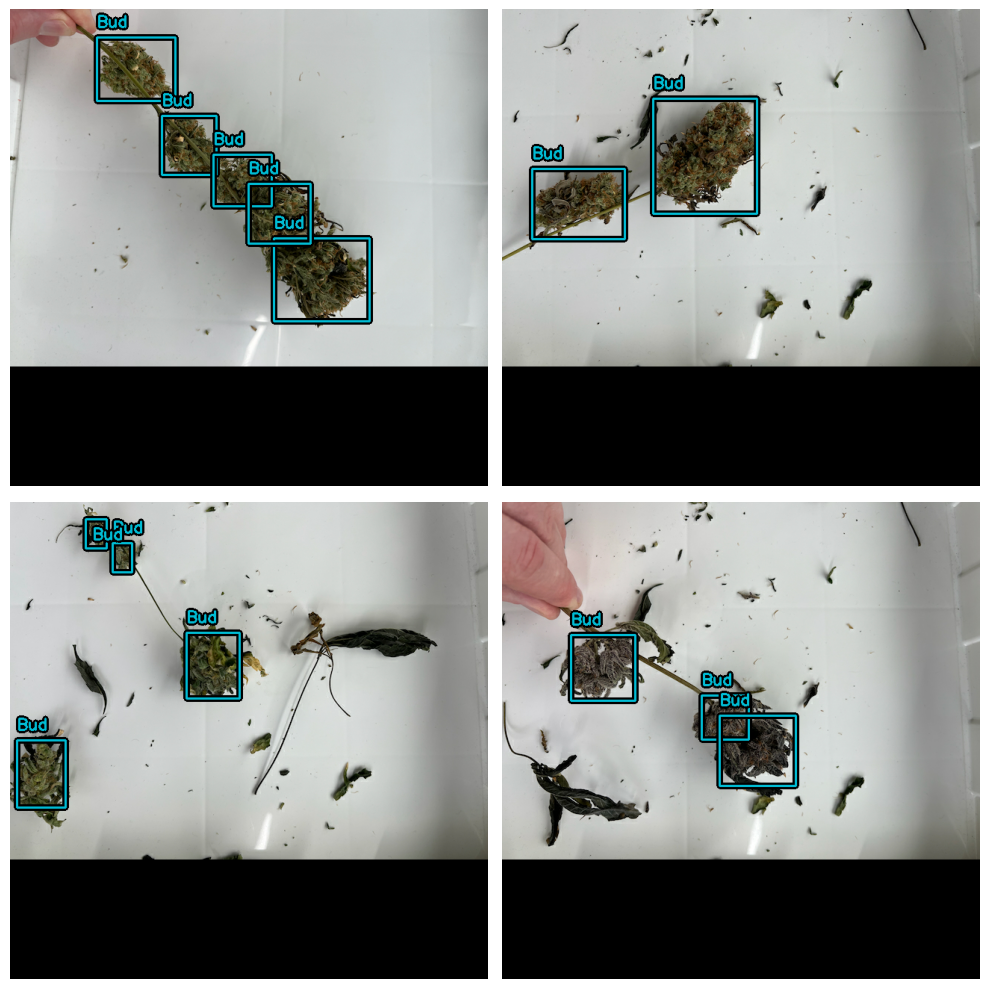

In [12]:
print(f'train_ds: {train_ds}')
print(f'val_ds: {val_ds}')

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    print(inputs)
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

    print(images)
    print(bounding_boxes)
    
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [13]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Create The Model

In [14]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [15]:
print(f'len(class_mapping) is {len(class_mapping)}')

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

len(class_mapping) is 1


# Compile the Model

In [16]:
# using optimizers.legacy.Adam instead of optimizers.Adam because of this message:
#
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs,
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [17]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path, save_format="tf")  # Save the model when mAP improves

        return logs

# Train the Model

In [18]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.tf")],
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 341.1860 - box_loss: 3.5119 - class_loss: 337.6741

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self.

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 64s 10s/step - loss: 341.1860 - box_loss: 3.5119 - class_loss: 337.6741 - val_loss: 455.4517 - val_box_loss: 4.1281 - val_class_loss: 451.3236 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 142.9572 - box_loss: 3.0279 - class_loss: 139.9293

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 32s 8s/step - loss: 142.9572 - box_loss: 3.0279 - class_loss: 139.9293 - val_loss: 6083.0317 - val_box_loss: 3.6053 - val_class_loss: 6079.4263 - MaP: 0.0014 - MaP@[IoU=50]: 0.0023 - MaP@[IoU=75]: 0.0023 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0059 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0429 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.2000
Epoch 3/50
5/5 [==============================] - 7s 1s/step - loss: 98.5927 - box_loss: 2.8875 - class_loss: 95.7052 - val_loss: 6187.0195 - val_box_loss: 4.2385 - val_class_loss: 6182.7812 - MaP: 2.7584e-04 - MaP@[IoU=50]: 0.0028 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.3240e-04 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_d

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 33s 8s/step - loss: 4.3043 - box_loss: 1.8949 - class_loss: 2.4094 - val_loss: 12.0768 - val_box_loss: 3.4696 - val_class_loss: 8.6072 - MaP: 0.0032 - MaP@[IoU=50]: 0.0084 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0137 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0222 - Recall@[max_detections=100]: 0.0500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.2250
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 3.9975 - box_loss: 1.9000 - class_loss: 2.0975

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 3.9975 - box_loss: 1.9000 - class_loss: 2.0975 - val_loss: 26.0091 - val_box_loss: 2.6443 - val_class_loss: 23.3647 - MaP: 0.0045 - MaP@[IoU=50]: 0.0273 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0394 - MaP@[area=large]: 0.0055 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0444 - Recall@[max_detections=100]: 0.0778 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0583 - Recall@[area=large]: 0.1750
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 3.7183 - box_loss: 1.7029 - class_loss: 2.0154

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 3.7183 - box_loss: 1.7029 - class_loss: 2.0154 - val_loss: 11.6787 - val_box_loss: 2.9351 - val_class_loss: 8.7436 - MaP: 0.0072 - MaP@[IoU=50]: 0.0296 - MaP@[IoU=75]: 0.0015 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0086 - MaP@[area=large]: 0.0180 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0429 - Recall@[max_detections=100]: 0.1429 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0250 - Recall@[area=large]: 0.3600
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 4.0678 - box_loss: 1.7596 - class_loss: 2.3081

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 4.0678 - box_loss: 1.7596 - class_loss: 2.3081 - val_loss: 4.9452 - val_box_loss: 2.5978 - val_class_loss: 2.3475 - MaP: 0.1140 - MaP@[IoU=50]: 0.2753 - MaP@[IoU=75]: 0.0396 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0637 - MaP@[area=large]: 0.3030 - Recall@[max_detections=1]: 0.0769 - Recall@[max_detections=10]: 0.2154 - Recall@[max_detections=100]: 0.2154 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1857 - Recall@[area=large]: 0.3000
Epoch 29/50
5/5 [==============================] - 10s 2s/step - loss: 3.5430 - box_loss: 1.6562 - class_loss: 1.8868 - val_loss: 10.7867 - val_box_loss: 2.7217 - val_class_loss: 8.0650 - MaP: 0.0225 - MaP@[IoU=50]: 0.0905 - MaP@[IoU=75]: 0.0017 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0667 - MaP@[area=large]: 0.0250 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.1118 - Recall@[max_detections=100]: 0.1706 - Recall@[area=small]: 0.000

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 3.5443 - box_loss: 1.7686 - class_loss: 1.7757 - val_loss: 5.1388 - val_box_loss: 2.7855 - val_class_loss: 2.3533 - MaP: 0.1155 - MaP@[IoU=50]: 0.4103 - MaP@[IoU=75]: 0.0132 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0789 - MaP@[area=large]: 0.3990 - Recall@[max_detections=1]: 0.0786 - Recall@[max_detections=10]: 0.1857 - Recall@[max_detections=100]: 0.1857 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1556 - Recall@[area=large]: 0.4000
Epoch 32/50
5/5 [==============================] - 9s 2s/step - loss: 3.2589 - box_loss: 1.6922 - class_loss: 1.5667 - val_loss: 6.6720 - val_box_loss: 2.3021 - val_class_loss: 4.3699 - MaP: 0.0554 - MaP@[IoU=50]: 0.1377 - MaP@[IoU=75]: 0.0069 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1723 - MaP@[area=large]: 0.0462 - Recall@[max_detections=1]: 0.0250 - Recall@[max_detections=10]: 0.1750 - Recall@[max_detections=100]: 0.2250 - Recall@[area=small]: 0.0000e+00 

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 33s 8s/step - loss: 3.0622 - box_loss: 1.6231 - class_loss: 1.4391 - val_loss: 4.1187 - val_box_loss: 2.3983 - val_class_loss: 1.7204 - MaP: 0.2123 - MaP@[IoU=50]: 0.5900 - MaP@[IoU=75]: 0.0264 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1607 - MaP@[area=large]: 0.3897 - Recall@[max_detections=1]: 0.1214 - Recall@[max_detections=10]: 0.2786 - Recall@[max_detections=100]: 0.2786 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2375 - Recall@[area=large]: 0.4000
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 2.7640 - box_loss: 1.4638 - class_loss: 1.3002

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 2.7640 - box_loss: 1.4638 - class_loss: 1.3002 - val_loss: 3.9880 - val_box_loss: 2.2503 - val_class_loss: 1.7377 - MaP: 0.3057 - MaP@[IoU=50]: 0.6436 - MaP@[IoU=75]: 0.2178 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2956 - MaP@[area=large]: 0.5337 - Recall@[max_detections=1]: 0.1357 - Recall@[max_detections=10]: 0.3143 - Recall@[max_detections=100]: 0.3143 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3111 - Recall@[area=large]: 0.5333
Epoch 36/50
5/5 [==============================] - 8s 2s/step - loss: 2.8624 - box_loss: 1.5059 - class_loss: 1.3565 - val_loss: 3.8949 - val_box_loss: 2.1658 - val_class_loss: 1.7291 - MaP: 0.2334 - MaP@[IoU=50]: 0.6412 - MaP@[IoU=75]: 0.0462 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1966 - MaP@[area=large]: 0.3828 - Recall@[max_detections=1]: 0.0692 - Recall@[max_detections=10]: 0.3462 - Recall@[max_detections=100]: 0.3462 - Recall@[area=small]: 0.0000e+00 

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 2.6683 - box_loss: 1.4286 - class_loss: 1.2397 - val_loss: 3.7251 - val_box_loss: 2.1387 - val_class_loss: 1.5864 - MaP: 0.3095 - MaP@[IoU=50]: 0.7770 - MaP@[IoU=75]: 0.1384 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3212 - MaP@[area=large]: 0.5000 - Recall@[max_detections=1]: 0.1571 - Recall@[max_detections=10]: 0.3571 - Recall@[max_detections=100]: 0.3571 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3889 - Recall@[area=large]: 0.5000
Epoch 43/50
5/5 [==============================] - 6s 1s/step - loss: 2.5431 - box_loss: 1.3420 - class_loss: 1.2011 - val_loss: 4.6105 - val_box_loss: 2.2674 - val_class_loss: 2.3432 - MaP: 0.2356 - MaP@[IoU=50]: 0.5050 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1683 - MaP@[area=large]: 0.2990 - Recall@[max_detections=1]: 0.1667 - Recall@[max_detections=10]: 0.2333 - Recall@[max_detections=100]: 0.2333 - Recall@[area=small]: 0.0000e

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 36s 8s/step - loss: 2.3360 - box_loss: 1.3103 - class_loss: 1.0257 - val_loss: 3.6622 - val_box_loss: 2.1597 - val_class_loss: 1.5025 - MaP: 0.3159 - MaP@[IoU=50]: 0.6656 - MaP@[IoU=75]: 0.1347 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3774 - MaP@[area=large]: 0.3495 - Recall@[max_detections=1]: 0.1429 - Recall@[max_detections=10]: 0.3571 - Recall@[max_detections=100]: 0.3571 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4333 - Recall@[area=large]: 0.3667
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 2.1948 - box_loss: 1.2145 - class_loss: 0.9802

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 35s 8s/step - loss: 2.1948 - box_loss: 1.2145 - class_loss: 0.9802 - val_loss: 3.6254 - val_box_loss: 2.2460 - val_class_loss: 1.3794 - MaP: 0.3289 - MaP@[IoU=50]: 0.8388 - MaP@[IoU=75]: 0.2063 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3281 - MaP@[area=large]: 0.4324 - Recall@[max_detections=1]: 0.1357 - Recall@[max_detections=10]: 0.4286 - Recall@[max_detections=100]: 0.4286 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4375 - Recall@[area=large]: 0.5000
Epoch 48/50
5/5 [==============================] - ETA: 0s - loss: 2.0592 - box_loss: 1.0949 - class_loss: 0.9644

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 33s 8s/step - loss: 2.0592 - box_loss: 1.0949 - class_loss: 0.9644 - val_loss: 3.5649 - val_box_loss: 2.0647 - val_class_loss: 1.5001 - MaP: 0.3415 - MaP@[IoU=50]: 0.7122 - MaP@[IoU=75]: 0.1605 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3598 - MaP@[area=large]: 0.5155 - Recall@[max_detections=1]: 0.0778 - Recall@[max_detections=10]: 0.4111 - Recall@[max_detections=100]: 0.4111 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4333 - Recall@[area=large]: 0.5500
Epoch 49/50
5/5 [==============================] - 8s 1s/step - loss: 2.0186 - box_loss: 1.1072 - class_loss: 0.9114 - val_loss: 3.8862 - val_box_loss: 2.2167 - val_class_loss: 1.6695 - MaP: 0.2723 - MaP@[IoU=50]: 0.6361 - MaP@[IoU=75]: 0.0792 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2869 - MaP@[area=large]: 0.3010 - Recall@[max_detections=1]: 0.1615 - Recall@[max_detections=10]: 0.3231 - Recall@[max_detections=100]: 0.3231 - Recall@[area=small]: 0.0000e+00 

# Visualize Predictions

1/1 [==============================] - 0s 457ms/step


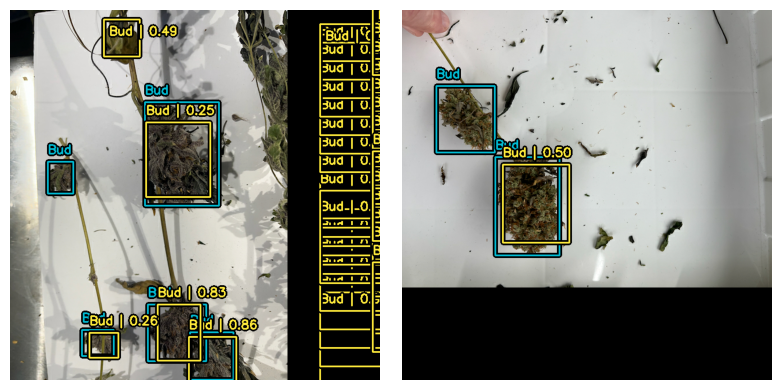

In [19]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")